In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import keras

# Best Model Definition

From what you can see in my notebooks, I have evaluated 7 different models, and here are the best one's according to RMSE:

In [2]:
data = {
    "Name": ["SVR", "FB Prophet", "CNN", "LSTM", "RNN"],
    "RMSE": [40.555, 26.301847, 26.410, 23.826, 21.449]
}
pd.DataFrame(data)

,Name,RMSE
0,SVR,40.555000
1,FB Prophet,26.301847
2,CNN,26.410000
3,LSTM,23.826000
4,RNN,21.449000


## Recomendation on the model choise:

I have tested several models with different approaches, and here when you should each of them:

1) Use classical ML models like Random Forest and SVR when you want to have full control of the model, and maybe want to use some heurisics or additional knowledge
2) Use FB Prophet library when you want to make some quick predictions and don't have time to get into the datat
3) Use DL methods, like LSTM, RNN, and CNN to get close to state-of-the-art performance, but without interpretability and control over the training 

## Prediction for the next year

In [6]:
# prepare the initial data:
from data_processing import process_data

REGIONS = [['JH', 'Johor', 'JH'], 
           ['PH', 'Pahang', 'PH'],
           ['PRK', 'Perak', 'PRK'], 
           ['OtherPEN', 'Other Pen. States', 'OtherPEN'],
           ['PEN', 'Peninsula', 'Pmalay'],
           ['SBH', 'Sabah', 'SBH'],
           ['SWK', 'Sarawak', 'SWK']]

production = pd.read_csv('../palm_oil_data/production_good.csv')
rainfall = pd.read_csv('../palm_oil_data/rainfall_good.csv')
area = pd.read_csv('../palm_oil_data/area_good.csv')

RAINFALL_LAGS = [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
PRODUCTION_LAGS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
DATA = process_data(production, rainfall, area, REGIONS, PRODUCTION_LAGS, RAINFALL_LAGS)
dates = DATA['Johor'][0].index
production.tail()



,index,Region,Year,Month,Production,Diff_production
2128,232,Production,2017,5,1654.494,84.032
2129,233,Production,2017,6,1514.170,106.441
2130,234,Production,2017,7,1827.108,-140.324
2131,235,Production,2017,8,1810.594,312.938
2132,236,Production,2017,9,1779.924,-16.514


In [7]:
# preparing the needed rainfall data for the next year

import datetime
new_rainfall = rainfall[rainfall["Region"] == "Johor"]
date1 = datetime.datetime.strptime("2017-10-01", "%Y-%m-%d")
new_rainfall["Date"] = pd.to_datetime(new_rainfall[['Year', 'Month']].assign(DAY=1))
new_rainfall = new_rainfall[new_rainfall["Date"] < date1]
new_rainfall = new_rainfall.sort_values(by="Date")
new_rainfall = new_rainfall.iloc[-13:]


C:\Users\m84200118\Anaconda3\envs\v-env\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
# function that predicts the production for a year long
def predict_year(DATA, best_model):
    results = []
    month = 0
    all_values = np.concatenate((DATA['Johor'][0].values, DATA['Johor'][1].values.reshape((-1, 1))), axis=1)

    for month in range(12):
        concatenated_values = all_values[-1:]

        # scaling values for RNN
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_values = scaler.fit_transform(all_values)

        last_example = scaled_values[-1:]
        last_example = last_example.reshape((last_example.shape[0], 1, last_example.shape[1]))

        x_test, _ = last_example[:, :,:-1], last_example[:, :,:-1]

        # Make a prediction for 1 day:
        day = best_model.predict(x_test)

        x_test = x_test.reshape((x_test.shape[0], x_test.shape[2]))
        # invert scaling for forecast
        yhat = np.concatenate((x_test, day), axis=1)
        yhat = scaler.inverse_transform(yhat)
        yhat = yhat[:,-1]
        # save the result
        results.append(yhat[0])

        # make an input for the future month to predict:
        concatenated_values[0][0] = (concatenated_values[0][0] % 12) +1
        for i in range(len(concatenated_values[0]) - 1, 0, -1):
            concatenated_values[0][i] = concatenated_values[0][i-1]
        concatenated_values[0][15] = yhat
        
        concatenated_values[0][1] = new_rainfall.iloc[month]["Rainfall"]
        np.append(concatenated_values[0], yhat)

        # appending future value to predict:
        np.append(all_values, concatenated_values)
    return results

In [13]:
best_model = keras.models.load_model('rnn_best')

forecast = predict_year(DATA, best_model)
forecast

[297.20766224157813,
 300.69163028120994,
 282.51326873326303,
 257.783521578908,
 250.26309804642202,
 240.1651449636221,
 247.47719728291037,
 238.53373182845115,
 233.52362023317815,
 244.53669488012792,
 256.05582680642607,
 272.0632615669966]

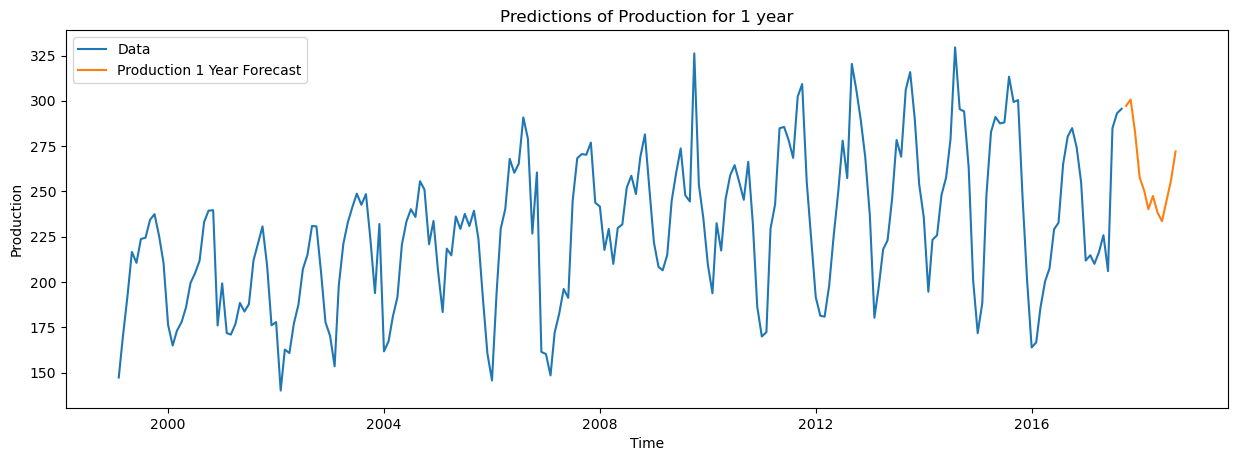

In [14]:
dates = pd.to_datetime(['2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
               '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01'])
plt.plot(DATA['Johor'][1], label="Data")
plt.plot(pd.Series(forecast, index=dates), label="Production 1 Year Forecast")
plt.xlabel("Time")
plt.ylabel("Production")
plt.title("Predictions of Production for 1 year")
plt.legend();

That was the hardest lab I have ever made :). WOW!